## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import matplotlib.pyplot as plt

% matplotlib inline

## Reading data

In [ ]:
train_df = pd.read_pickle('/content/drive/MyDrive/Project/train_preprocessed.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/Project/test_preprocessed.pkl')

## Understanding data

In [ ]:
columns, train_label_length, test_label_length = [], [], []
for col in train_df.columns:
  if(train_df[col].dtype == 'object'):
    columns.append(col)
    train_label_length.append(len(train_df[col].unique()))
    test_label_length.append(len(test_df[col].unique()))
data = {'Column name': columns, 'Train label length': train_label_length, 'Test label length': test_label_length}
df = pd.DataFrame(data=data).sort_values(by=['Train label length'], ascending=False)

In [ ]:
df[df['Train label length'] < df['Test label length']]

,Column name,Train label length,Test label length
0,MSSubClass,15,16
49,GarageCars,5,6
60,Bathrooms,5,6
44,Fireplaces,4,5
37,FullBath,4,5


We can see that 4 columns have extra labels in test data set, and if we do feature engineering based on train data set it will be a problem as we are ignoring the labels present in test data set. To overcome this issue, we are combing train and test data sets.

Combining train and test data sets

In [ ]:
# since test dataset does not have target variable, droping the target variable from train data while combining the data sets
df_all =  pd.concat([train_df.drop('SalePrice', axis=1), test_df])


In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   object 
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2919 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   object 
 17  OverallCond    2919 non-null   object 
 18  YearBuil

Checking the correlation between numeric columns and target variable

In [ ]:
train_df.corr()['SalePrice'][:].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.612166
1stFlrSF         0.605852
MasVnrArea       0.473461
TotalPorchAr     0.390993
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214198
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
MiscVal         -0.021190
LowQualFinSF    -0.025606
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

Based on EDA we found that some of the categorical values does not have much impact on the target variable, so we are dropping those columns along with the numeric columns that have less correlation with the target variable.

In [ ]:
df_all['Has2ndFlr'] = df_all['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
cols_to_drop = [
        'BsmtFinSF1', 
        'BsmtFinSF2', 
        'BsmtUnfSF',
        '1stFlrSF', 
        '2ndFlrSF', 
        'LowQualFinSF', 
        'BsmtFullBath', 
        'BsmtHalfBath', 
        'FullBath', 
        'HalfBath', 
        'WoodDeckSF', 
        'OpenPorchSF', 
        'EnclosedPorch', 
        '3SsnPorch', 
        'ScreenPorch',
        'MiscVal',
        'PoolArea',
        'LotArea',
        'WoodDeckSF',
        'Heating'
    ]

In [ ]:
df_new = df_all.drop(cols_to_drop, axis=1)

In [ ]:
df_new.shape

(2919, 64)

Finding the columns that are skewed

In [ ]:
def find_skew(dataset, show=True, col_names=False):
  df_skew = pd.DataFrame(dataset.select_dtypes(np.number).columns, columns=['Feature'])
  df_skew['Skew'] = df_skew['Feature'].apply(lambda feature: scipy.stats.skew(dataset[feature]))
  df_skew['Absolute Skew'] = df_skew['Skew'].apply(abs)
  df_skew['Skewed'] = df_skew['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

  if show:
    from IPython.display import display
    display(df_skew)

  if col_names:
    return df_skew[df_skew['Absolute Skew'] >= 0.5]['Feature'].values

find_skew(df_new)

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,1.672470,1.672470,True
1,MasVnrArea,2.624724,2.624724,True
2,TotalBsmtSF,1.141352,1.141352,True
3,GrLivArea,1.269358,1.269358,True
4,GarageArea,0.236857,0.236857,False
5,TotalPorchAr,1.376649,1.376649,True
6,Has2ndFlr,0.288675,0.288675,False


In [ ]:
# using boxcox transformations to reduce the skewness
skewed_cols = find_skew(df_new, show=False, col_names=True)

for col in skewed_cols:
  df_new[col] = boxcox1p(df_new[col], boxcox_normmax(df_new[col] + 1))

find_skew(df_new)

,Feature,Skew,Absolute Skew,Skewed
0,LotFrontage,0.051218,0.051218,False
1,MasVnrArea,0.982363,0.982363,True
2,TotalBsmtSF,0.369317,0.369317,False
3,GrLivArea,0.004848,0.004848,False
4,GarageArea,0.236857,0.236857,False
5,TotalPorchAr,0.186593,0.186593,False
6,Has2ndFlr,0.288675,0.288675,False


We can observe that the skewness is reduced for all the columns

In [ ]:
cols_not_to_be_encoded = ['YearBuilt', 'YearRemodAdd', 'GarageCars', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'MoSold', 'YrSold', 'Bathrooms', 'BsmtBathrooms']

df_new[cols_not_to_be_encoded] = df_new[cols_not_to_be_encoded].astype('int64')

In [ ]:
df_new = pd.get_dummies(df_new, drop_first=True)

In [ ]:
df_new.shape

(2919, 269)

### Target transformation

It is important is to check whether the target variable is normally distributed or not. If it's not then we need to perform some transformations so as to get it closer to normal distribution.

In [ ]:
target = train_df['SalePrice']
log_target = np.log(target)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


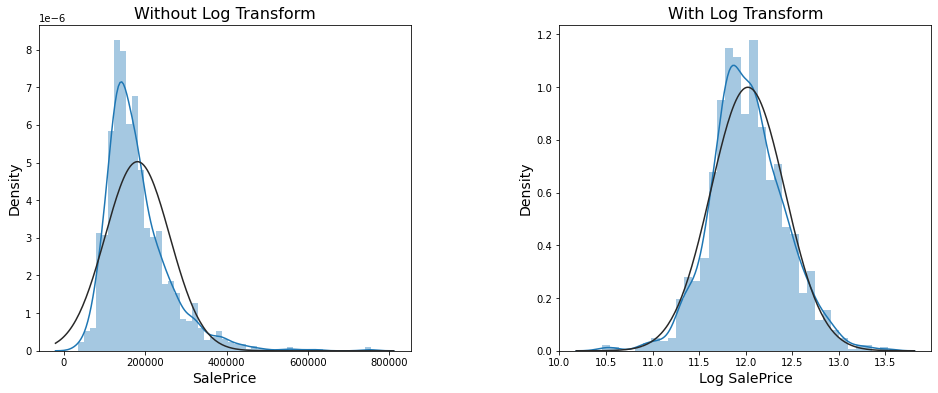

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.distplot(target, fit=scipy.stats.norm)
plt.xlabel('SalePrice', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Without Log Transform', fontsize=16)

plt.subplot(1, 2, 2)
sns.distplot(log_target, fit=scipy.stats.norm)
plt.xlabel('Log SalePrice', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('With Log Transform', fontsize=16)
plt.subplots_adjust(wspace=.4)

We can observe that the traget variable with log tranform is closer to the normal distribution. So, we will use the transformed target variable in the future.

### Saving data

In [ ]:
df_train_engineered = df_new[:1460]
df_test_engineered = df_new[1460:]

In [ ]:
# pickle preprocessed train data
df_train_engineered.to_pickle('/content/drive/MyDrive/Project/X_train.pkl')

# pickle preprocessed test data
df_test_engineered.to_pickle('/content/drive/MyDrive/Project/X_test.pkl')

log_target.to_pickle('/content/drive/MyDrive/Project/y_train.pkl')